## PARALLEL WORKFLOWS

### NON-LLM BASED

In [45]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict


In [46]:
class BatsmanState(TypedDict):

    runs: int
    balls: int
    fours: int
    sixes: int

    sr: float #strike rate
    bpb: float #boundary per ball
    boundary_percent: float 
    summary: str

In [47]:
def calculate_sr(state: BatsmanState) -> float:

    sr  = (state['runs'] / state['balls']) * 100

    state['sr'] = sr

    return {'sr': sr}


def calculate_bpb(state: BatsmanState) -> float:
    
    bpb  = (state['fours'] + state['sixes']) / state['balls']

    state['bpb'] = bpb

    return {'bpb': bpb}

def calculate_boundary_percent(state: BatsmanState) -> float:
    
    boundary_percent  = ((state['fours'] + state['sixes']) / state['runs']) * 100

    state['boundary_percent'] = boundary_percent

    return {'boundary_percent': boundary_percent}


def summary(state: BatsmanState) -> str:

    summary = f"""
    strile_rate - {state['sr']}\n
    Balls per boundary - {state['bpb']} \n
    Boundary percent - {state['boundary_percent']}
    """

    state['summary'] = summary

    return state  #or you can return {'summary': summary}#above states would conflict but not here since we are at the end


#for parallel we can use partial updates inside{ } like we did before and it can be used in sequential too

In [48]:
graph = StateGraph(BatsmanState)

In [49]:
graph.add_node('calculate_sr', calculate_sr)
graph.add_node('calculate_bpb', calculate_bpb)
graph.add_node('calculate_boundary_percent', calculate_boundary_percent)
graph.add_node('summary', summary)

graph.add_edge(START, 'calculate_sr')
graph.add_edge(START, 'calculate_bpb')
graph.add_edge(START, 'calculate_boundary_percent')

graph.add_edge('calculate_sr', 'summary')
graph.add_edge('calculate_bpb', 'summary') 
graph.add_edge('calculate_boundary_percent', 'summary')

graph.add_edge('summary', END)

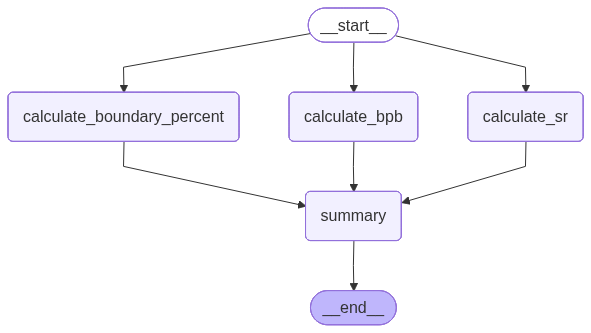

In [50]:
graph.compile()

In [51]:
workflow = graph.compile()

In [52]:
initial_state = {'runs': 100, 'balls': 80, 'fours': 10, 'sixes': 5}
final_state = workflow.invoke(initial_state)

final_state

{'runs': 100,
 'balls': 80,
 'fours': 10,
 'sixes': 5,
 'sr': 125.0,
 'bpb': 0.1875,
 'boundary_percent': 15.0,
 'summary': '\n    strile_rate - 125.0\n\n    Balls per boundary - 0.1875 \n\n    Boundary percent - 15.0\n    '}



### LLM-BASED

In [67]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel, Field

#imports for reducers
import operator
from typing import Annotated

In [6]:
load_dotenv()

True

In [23]:
import os
GROK_API_KEY = os.getenv("GROK_API_KEY")

In [34]:
# we have to choose the model that supports structured output (you will know the reason after doing below coding) 

In [56]:
model = ChatGroq(api_key=GROK_API_KEY, model ="qwen/qwen3-32b")

In [57]:
# we will tell rule or schema to the model that we make through pydantic

class EvaluationSchema(BaseModel):

    score: int = Field(description="Score out of 10", ge=0 , le=10) #greater than equal to 0 and less than equal to 10
    feedback: str = Field(description="Detailed feedback on the performance")

In [58]:
structured_model = model.with_structured_output(EvaluationSchema)

In [59]:
essay = """ In the heart of the bustling city, there lay a hidden garden, untouched by time and chaos. This garden was a sanctuary for those seeking solace from the relentless pace of urban life. Towering trees provided shade, while vibrant flowers painted the landscape with colors that seemed almost surreal. A gentle stream meandered through the garden, its soothing sounds creating a melody that calmed the soul. """

In [60]:
prompt = f"""
Evaluate the following essay on a scale of 0 to 10 based on coherence, creativity, grammar, and overall impact. Provide constructive feedback to help improve the essay.
{essay}"""

In [64]:
result = structured_model.invoke(prompt)
result

EvaluationSchema(score=7, feedback="The essay exhibits strong coherence and vivid imagery, particularly in describing the hidden garden's tranquil atmosphere. However, it lacks depth and originality in its metaphors (e.g., 'sanctuary,' 'melody'), relying on familiar phrases. To strengthen it, explore unique sensory details, add a narrative element (e.g., a visitor's experience), and provide a concluding reflection. Grammar is sound.")

In [65]:
result.score

7

In [66]:
result.feedback

"The essay exhibits strong coherence and vivid imagery, particularly in describing the hidden garden's tranquil atmosphere. However, it lacks depth and originality in its metaphors (e.g., 'sanctuary,' 'melody'), relying on familiar phrases. To strengthen it, explore unique sensory details, add a narrative element (e.g., a visitor's experience), and provide a concluding reflection. Grammar is sound."

#NOW WE KNOW STRUCTURE OUTPUT (HOW TO MAKE IT)


LET'S MAKE WORKFLOW NOW WITH THIS

In [69]:
class EngState(TypedDict):  #we are basically testing essay for any literature student

    essay: str #essay

    language_feedback: str #feedbacks
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str

    individual_scores: Annotated[list[int], operator.add]  #list of scores
    avg_score: float
    #(above we used reducers to merge all scores into a list) and operator.add works as for adding elements to the list


In [89]:
def language_evaluation(state: EngState):

    prompt = f"""
    Evaluate the following essay on a scale of 0 to 10 based on language use, grammar, and vocabulary. Provide constructive feedback to help improve the essay.
    {state['essay']}"""
    
    result = structured_model.invoke(prompt)
    
    state['language_feedback'] = result.feedback
    
    return {'individual_scores': [result.score], 'language_feedback': result.feedback}  #returning as list for reducer to work


def analysis_evaluation(state: EngState):
    
    prompt = f"""
    Evaluate the following essay on a scale of 0 to 10 based on depth of analysis, argument strength, and evidence use. Provide constructive feedback to help improve the essay.
    {state['essay']}"""
    
    result = structured_model.invoke(prompt)
    
    state['analysis_feedback'] = result.feedback
    
    return {'individual_scores': [result.score], 'analysis_feedback': result.feedback}


def clarity_evaluation(state: EngState):
    
    prompt = f"""
    Evaluate the following essay on a scale of 0 to 10 based on clarity, organization, and flow. Provide constructive feedback to help improve the essay.
    {state['essay']}"""
    
    result = structured_model.invoke(prompt)
    
    state['clarity_feedback'] = result.feedback
    
    return {'individual_scores': [result.score], 'clarity_feedback': result.feedback}


def overall_evaluation(state: EngState):
    
    #avg score calculation
    avg_score = sum(state['individual_scores']) / len(state['individual_scores'])

    #summary feedback
    prompt = f'based on the following feedbacks, provide an overall feedback to improve the essay:\n Language Feedback: {state["language_feedback"]}\n Analysis Feedback: {state["analysis_feedback"]}\n Clarity Feedback: {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content   #here we do not require structured output 

    return {'avg_score': avg_score, 'overall_feedback': overall_feedback}

In [90]:
graph = StateGraph(EngState)

In [91]:
graph.add_node('language_evaluation', language_evaluation)
graph.add_node('analysis_evaluation', analysis_evaluation)
graph.add_node('clarity_evaluation', clarity_evaluation)
graph.add_node('overall_evaluation', overall_evaluation)

graph.add_edge(START, 'language_evaluation')
graph.add_edge(START, 'analysis_evaluation')
graph.add_edge(START, 'clarity_evaluation')

graph.add_edge('language_evaluation', 'overall_evaluation')
graph.add_edge('analysis_evaluation', 'overall_evaluation')
graph.add_edge('clarity_evaluation', 'overall_evaluation')

graph.add_edge('overall_evaluation', END)

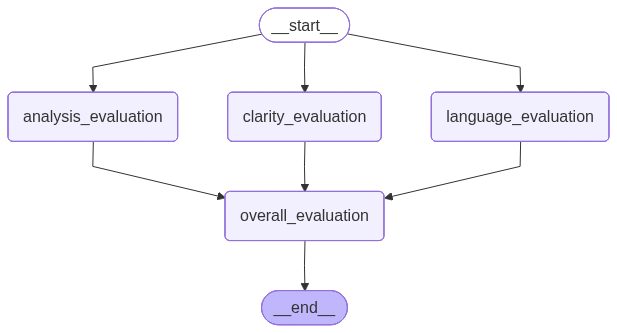

In [92]:
graph.compile()

In [93]:
workflow = graph.compile()

In [94]:
initial_state = {'essay': essay}
final_state = workflow.invoke(initial_state)

In [95]:
final_state

{'essay': ' In the heart of the bustling city, there lay a hidden garden, untouched by time and chaos. This garden was a sanctuary for those seeking solace from the relentless pace of urban life. Towering trees provided shade, while vibrant flowers painted the landscape with colors that seemed almost surreal. A gentle stream meandered through the garden, its soothing sounds creating a melody that calmed the soul. ',
 'language_feedback': "The essay demonstrates strong language use with vivid imagery and a rich vocabulary (e.g., 'untouched by time and chaos,' 'surreal'). Grammar is mostly correct, though 'there lay' could be modernized to 'there was' for clarity. Sentences flow smoothly, but could benefit from varied structure to avoid repetition of 'while' and 'creating.' Add a concluding sentence to strengthen the reflective tone.",
 'analysis_feedback': "The essay creates a vivid, sensory-rich description of the garden, but lacks analytical depth, argumentative structure, and support

### (above we used structured output, reducers with llms)